# Import Libraries

In [1]:
import os
import csv
import math
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nibabel as nib
import seaborn as sns

In [2]:
csv_file = "ADNI1_Complete_1Yr_1.5T_11_18_2022.csv"
dataset_path = "D:/Senior Project/ADNI/"

# Read CSV

- CSV file contains information about subjects and their stages.

In [3]:
def read_csv():
    with open(filename, 'r') as f:
        for line in csv.reader(f):
            print(line)

In [ ]:
read_csv()

# View .nii Files

- The function below changes the format of the nii file to jpg file

In [4]:
def format_as_jpg(input_file):
    img = nib.load(input_file)
    img_data = img.get_fdata()
    shape = img_data.shape
    slice_list = []
    for i in range(0, shape[2]):
        slice_list.append(img_data[:, :, i])
    fig = plt.figure(figsize=(8, 8))
    columns = 16
    rows = math.ceil((shape[2]) / columns)
    gs1 = gridspec.GridSpec(rows, columns)
    gs1.update(wspace=0, hspace=0)
    for i in range(0, shape[2]):
        fig.add_subplot(gs1[i], xticks=[], yticks=[])
        plt.imshow(slice_list[i], cmap="gray", origin="upper", aspect="auto")
    plt.savefig(input_file + '.jpg', bbox_inches='tight')

# Data Preperation

1. get_filenames() function returns a list that contains the path of 
   the .nii files and their stages. 
   
   
2. The function appends 1 to to the list if the stage is AD (Alzhiemer's Disease),
   appends 0 if the stage is MCI (Mild Cognitive Impairment).

In [3]:
def get_filenames():
    
    file_list = [] # list of all files and stages
    
    with open(csv_file, 'r') as f:
        
        for line in csv.reader(f):
            
            if line[2] == 'MCI':
                modality = (line[7].replace(';', '_')).replace(' ', '_') # filenames has underscores instead of ';' and ' '
                path = dataset_path + line[1] + '/' + modality
                
                for i in os.listdir(path):
                    path2 = path + '/' + i
                    for j in os.listdir(path2):
                        path3 = path2 + '/' + j
                        for k in os.listdir(path3):
                            last_path = path3 + '/' + k
                            
                file_list.append([0, last_path]) # 0 for MCI
                
            elif line[2] == 'AD':
                modality = (line[7].replace(';', '_')).replace(' ', '_') # filenames has underscores instead of ';' and ' '
                path = dataset_path + line[1] + '/' + modality
                
                for i in os.listdir(path):
                    path2 = path + '/' + i
                    for j in os.listdir(path2):
                        path3 = path2 + '/' + j
                        for k in os.listdir(path3):
                            last_path = path3 + '/' + k
                            
                file_list.append([1, last_path]) # 1 for AD
                
    return file_list

In [4]:
data = []  # list for image data
result = []  # list for stages of image data (0 , 1) = (MCI, AD)
filenames = get_filenames()
encoder = OneHotEncoder()
encoder.fit([[0], [1]])  # 0 MCI, 1 AD

OneHotEncoder()

In [5]:
for path in filenames:
    img = nib.load(path[1]) # loads NIFTI image
    img_data = img.get_fdata()  # 256x256x160 array
    img_data = img_data[:, :, 80]  # middle slice of the array 256x256x1
    image = Image.fromarray(img_data) 
    image = image.convert('RGB')
    img_data = np.array(image)
    
    if img_data.shape == (256, 256, 3):  # checks all images for the same format
        data.append(np.array(img_data))
        result.append(encoder.transform([[path[0]]]).toarray())

In [6]:
data = np.array(data)
test_data = data[:100]
data = data[100:]
result = np.array(result)
result = result[:, 0, :]
test_result = result[:100]
result = result[100:]
print(data.shape)  # 908 images
print(test_data.shape)  # 100 images
print(result.shape)  # 908 results
print(test_result.shape)  # 100 test results

(908, 256, 256, 3)
(100, 256, 256, 3)
(908, 2)
(100, 2)


# Splitting the Data into Training & Testing

In [10]:
x_train, x_test, y_train, y_test = train_test_split(data, result, test_size=0.2, shuffle=True, random_state=0)

# CNN Model

In [11]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(256, 256, 3), padding='Same'))
model.add(Conv2D(32, kernel_size=(2, 2),  activation='relu', padding='Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(2, 2), activation='relu', padding='Same'))
model.add(Conv2D(64, kernel_size=(2, 2), activation='relu', padding='Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer='Adamax', metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      416       
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      4128      
                                                                 
 batch_normalization_2 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 64)     

Epoch 1/30
23/23 [==============================] - 117s 5s/step - loss: 76.6699 - accuracy: 0.6143 - val_loss: 35.5864 - val_accuracy: 0.6538
Epoch 2/30
23/23 [==============================] - 117s 5s/step - loss: 9.8239 - accuracy: 0.7603 - val_loss: 7.7740 - val_accuracy: 0.5330
Epoch 3/30
23/23 [==============================] - 123s 5s/step - loss: 1.4908 - accuracy: 0.9091 - val_loss: 4.0032 - val_accuracy: 0.6758
Epoch 4/30
23/23 [==============================] - 118s 5s/step - loss: 0.9835 - accuracy: 0.9284 - val_loss: 3.7962 - val_accuracy: 0.6319
Epoch 5/30
23/23 [==============================] - 117s 5s/step - loss: 0.6474 - accuracy: 0.9394 - val_loss: 3.7430 - val_accuracy: 0.8516
Epoch 6/30
23/23 [==============================] - 134s 6s/step - loss: 0.2128 - accuracy: 0.9601 - val_loss: 4.4194 - val_accuracy: 0.7912
Epoch 7/30
23/23 [==============================] - 118s 5s/step - loss: 0.1515 - accuracy: 0.9725 - val_loss: 5.2665 - val_accuracy: 0.8626
Epoch 8/30


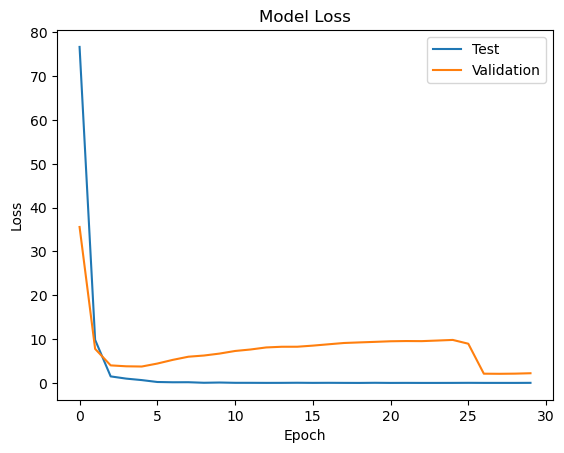

In [12]:
history = model.fit(x_train, y_train, epochs=30, batch_size=32, verbose=1, validation_data=(x_test, y_test))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

In [13]:
predictions = np.argmax(model.predict(x_train), axis=1)
y_train_results = np.argmax(y_train, axis=1)
print(classification_report(y_train_results, predictions, target_names=['MCI', 'AD']))

23/23 [==============================] - 17s 662ms/step
              precision    recall  f1-score   support

         MCI       1.00      0.96      0.98       491
          AD       0.92      1.00      0.96       235

    accuracy                           0.97       726
   macro avg       0.96      0.98      0.97       726
weighted avg       0.97      0.97      0.97       726



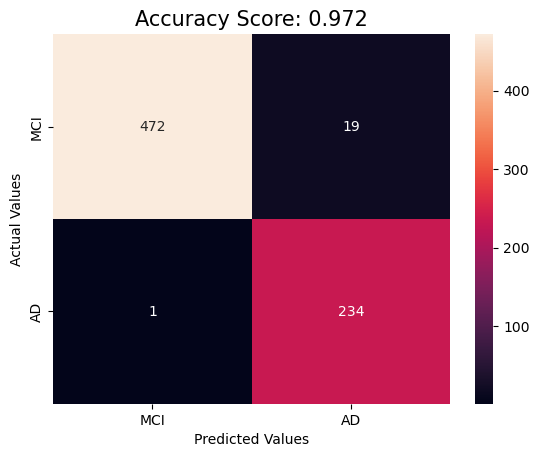

In [18]:
score = round(accuracy_score(y_train_results, predictions), 3)
cm = confusion_matrix(y_train_results, predictions)
sns.heatmap(cm, annot=True, fmt=".0f", xticklabels = ['MCI', 'AD'], yticklabels = ['MCI', 'AD'])
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size=15)
plt.show()

In [19]:
test_predictions = np.argmax(model.predict(x_test), axis=1)
y_test_results = np.argmax(y_test, axis=1)
print(classification_report(y_test_results, test_predictions, target_names=['MCI', 'AD']))

6/6 [==============================] - 5s 682ms/step
              precision    recall  f1-score   support

         MCI       0.92      0.91      0.92       119
          AD       0.83      0.86      0.84        63

    accuracy                           0.89       182
   macro avg       0.88      0.88      0.88       182
weighted avg       0.89      0.89      0.89       182



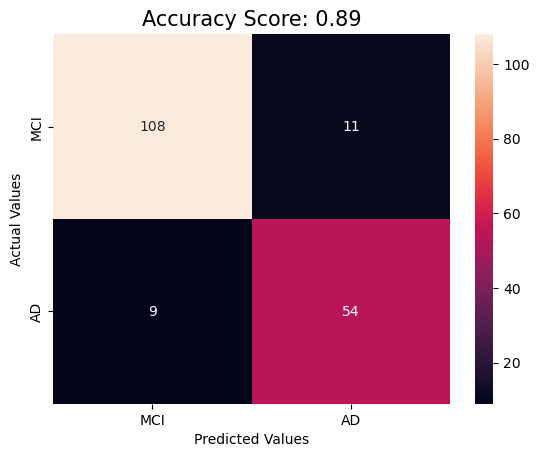

In [20]:
score = round(accuracy_score(y_test_results, test_predictions), 3)
cm = confusion_matrix(y_test_results, test_predictions)
sns.heatmap(cm, annot=True, fmt=".0f", xticklabels = ['MCI', 'AD'], yticklabels = ['MCI', 'AD'])
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size=15)
plt.show()

In [21]:
final_predictions = np.argmax(model.predict(test_data), axis=1)
final_results = np.argmax(test_result, axis=1)
print(classification_report(final_results, final_predictions, target_names=['MCI', 'AD']))

4/4 [==============================] - 4s 464ms/step
              precision    recall  f1-score   support

         MCI       0.73      0.72      0.72        71
          AD       0.33      0.34      0.34        29

    accuracy                           0.61       100
   macro avg       0.53      0.53      0.53       100
weighted avg       0.61      0.61      0.61       100



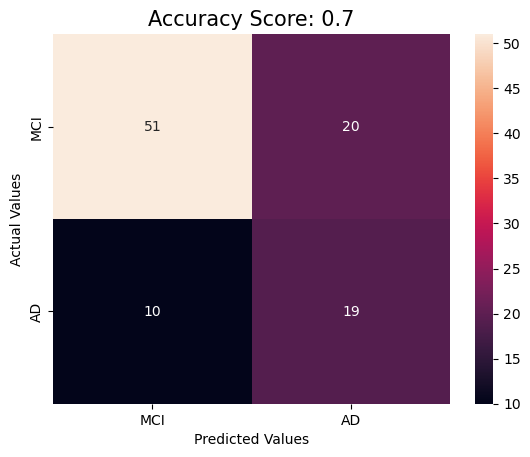

In [41]:
score = round(accuracy_score(final_results, final_predictions), 3)
cm = confusion_matrix(final_results, final_predictions)
sns.heatmap(cm, annot=True, fmt=".0f", xticklabels = ['MCI', 'AD'], yticklabels = ['MCI', 'AD'])
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size=15)
plt.show()